# Calibration and Thresholds

This notebook covers:
- Probability calibration evaluation (reliability curves, ECE)
- Calibration methods (Platt scaling, Isotonic regression)
- Comparison of calibrated vs uncalibrated models
- Threshold analysis for different use cases
- Selection of best calibrated model

Since this is a "win probability" task, well-calibrated probabilities are essential.


In [43]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score, confusion_matrix

# Import project utilities
# Add project root to path (notebooks are in notebooks/ folder, src is in parent)
project_root = Path(__file__).parent.parent if '__file__' in globals() else Path('../').resolve()
sys.path.insert(0, str(project_root))
from src import data, features, model, eval, viz

warnings.filterwarnings('ignore')

# Set style
viz.set_plot_style()

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load Data and Recreate Models

We'll recreate the models from notebook 02 to ensure consistency.


In [44]:
# Load data
data_path = Path('../data/raw/high_diamond_ranked_10min.csv')
df = data.load_data(data_path)

# Apply feature engineering
df_eng = features.create_engineered_features(df)
target = 'blueWins'
X, y = data.prepare_target_features(df_eng, target=target, exclude_cols=['gameId'])

# Train/test split (same as notebook 02)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")


Training set: 7,903 samples
Test set: 1,976 samples


In [45]:
# Recreate models (same as notebook 02)
models = {}

# Logistic Regression
scaler = model.prepare_scaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = model.create_logistic_regression(random_state=RANDOM_STATE)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = {
    'model': lr_model,
    'scaler': scaler,
    'needs_scaling': True
}

# HistGradientBoosting
hgb_model = model.create_hist_gradient_boosting(random_state=RANDOM_STATE)
hgb_model.fit(X_train, y_train)
models['HistGradientBoosting'] = {
    'model': hgb_model,
    'scaler': None,
    'needs_scaling': False
}

print("[OK] Models recreated successfully")


[OK] Models recreated successfully


## 2. Get Uncalibrated Predictions


In [46]:
# Get uncalibrated predictions
uncalibrated_predictions = {}

for name, model_dict in models.items():
    model_obj = model_dict['model']
    scaler = model_dict['scaler']
    needs_scaling = model_dict['needs_scaling']
    
    if needs_scaling:
        X_test_pred = X_test_scaled
    else:
        X_test_pred = X_test
    
    y_test_proba = model_obj.predict_proba(X_test_pred)[:, 1]
    
    uncalibrated_predictions[name] = y_test_proba
    print(f"[OK] Predictions generated for {name}")

print(f"\nUncalibrated predictions shape: {uncalibrated_predictions['Logistic Regression'].shape}")


[OK] Predictions generated for Logistic Regression
[OK] Predictions generated for HistGradientBoosting

Uncalibrated predictions shape: (1976,)


## 3. Evaluate Calibration - Reliability Curves

Reliability curves (calibration plots) show how well the predicted probabilities match the actual frequencies.


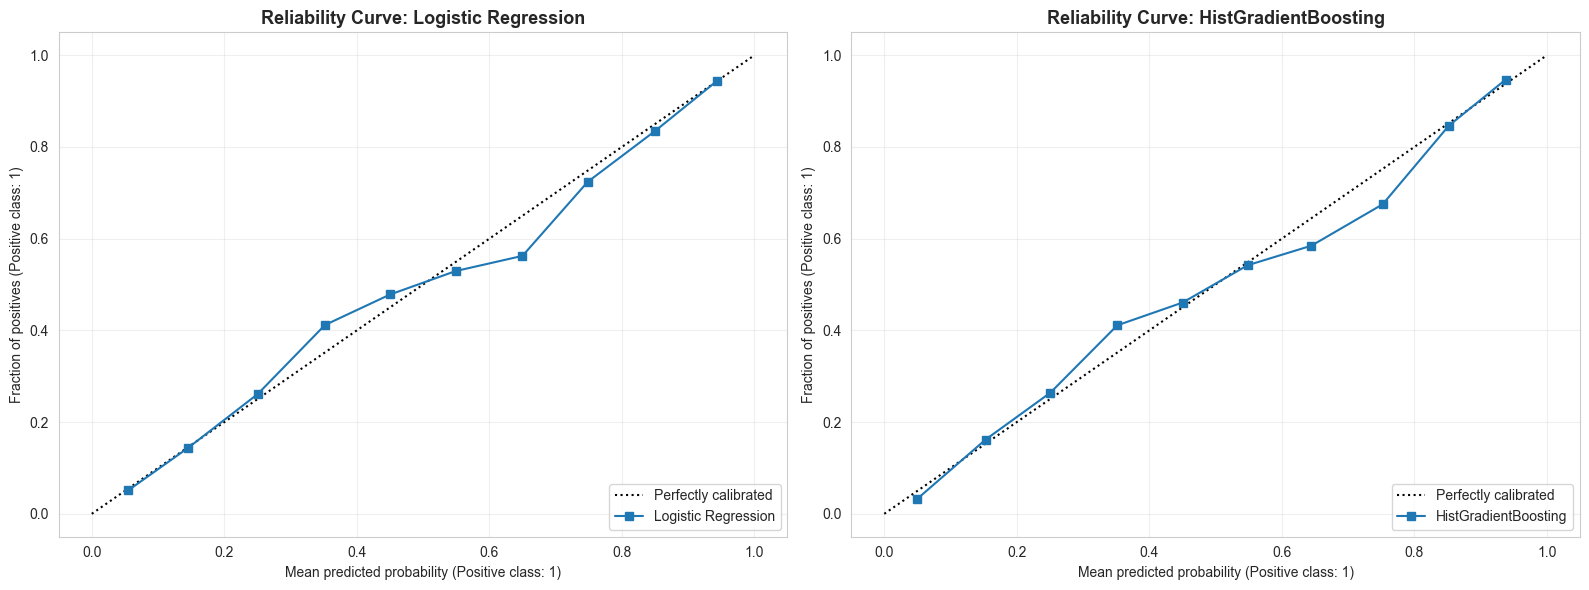

In [47]:
# Plot reliability curves for uncalibrated models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (name, y_proba) in enumerate(uncalibrated_predictions.items()):
    ax = axes[idx]
    
    # Create calibration display
    display = CalibrationDisplay.from_predictions(
        y_test, y_proba,
        n_bins=10,
        ax=ax,
        name=name
    )
    ax.set_title(f'Reliability Curve: {name}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Calculate Calibration Metrics

We'll calculate Expected Calibration Error (ECE) and Brier Score to quantify calibration quality.


In [48]:
# Calculate calibration metrics for uncalibrated models
calibration_metrics = []

for name, y_proba in uncalibrated_predictions.items():
    metrics = eval.calculate_calibration_metrics(y_test, y_proba)
    
    calibration_metrics.append({
        'Model': name,
        'Calibration': 'Uncalibrated',
        'ECE': metrics['ece'],
        'Brier Score': metrics['brier_score'],
        'Log Loss': metrics['log_loss']
    })

calibration_df = pd.DataFrame(calibration_metrics)
print("Calibration Metrics (Uncalibrated):")
print("=" * 70)
print(calibration_df.round(4).to_string(index=False))
print("=" * 70)


Calibration Metrics (Uncalibrated):
               Model  Calibration    ECE  Brier Score  Log Loss
 Logistic Regression Uncalibrated 0.0260       0.1799    0.5318
HistGradientBoosting Uncalibrated 0.0272       0.1819    0.5355


## 5. Apply Calibration Methods

We'll apply two calibration methods:
1. **Platt Scaling** (sigmoid calibration) - parametric method
2. **Isotonic Regression** - non-parametric method


In [49]:
# Apply calibration to all models
calibrated_models = {}

for name, model_dict in models.items():
    base_model = model_dict['model']
    scaler = model_dict['scaler']
    needs_scaling = model_dict['needs_scaling']
    
    # Prepare training data for calibration
    if needs_scaling:
        X_train_cal = X_train_scaled
        X_test_cal = X_test_scaled
    else:
        X_train_cal = X_train
        X_test_cal = X_test
    
    # Create calibrated models with both methods
    calibrated_models[name] = {}
    
    # Platt Scaling (sigmoid)
    print(f"Calibrating {name} with Platt Scaling...")
    platt_calibrated = model.create_calibrated_model(base_model, method='sigmoid')
    platt_calibrated.fit(X_train_cal, y_train)
    calibrated_models[name]['Platt'] = platt_calibrated
    
    # Isotonic Regression
    print(f"Calibrating {name} with Isotonic Regression...")
    isotonic_calibrated = model.create_calibrated_model(base_model, method='isotonic')
    isotonic_calibrated.fit(X_train_cal, y_train)
    calibrated_models[name]['Isotonic'] = isotonic_calibrated

print("\n[OK] All models calibrated successfully")


Calibrating Logistic Regression with Platt Scaling...
Calibrating Logistic Regression with Isotonic Regression...
Calibrating HistGradientBoosting with Platt Scaling...
Calibrating HistGradientBoosting with Isotonic Regression...

[OK] All models calibrated successfully


## 6. Get Calibrated Predictions


In [50]:
# Get calibrated predictions
calibrated_predictions = {}

for name in models.keys():
    calibrated_predictions[name] = {}
    
    # Prepare test data
    model_dict = models[name]
    if model_dict['needs_scaling']:
        X_test_cal = X_test_scaled
    else:
        X_test_cal = X_test
    
    # Get predictions for each calibration method
    for cal_method in ['Platt', 'Isotonic']:
        calibrated_model = calibrated_models[name][cal_method]
        y_proba = calibrated_model.predict_proba(X_test_cal)[:, 1]
        calibrated_predictions[name][cal_method] = y_proba

print("[OK] Calibrated predictions generated")


[OK] Calibrated predictions generated


## 7. Compare Calibration - All Methods


In [51]:
# Calculate metrics for all models and calibration methods
all_metrics = []

# Uncalibrated
for name, y_proba in uncalibrated_predictions.items():
    cal_metrics = eval.calculate_calibration_metrics(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    all_metrics.append({
        'Model': name,
        'Calibration': 'Uncalibrated',
        'ECE': cal_metrics['ece'],
        'Brier Score': cal_metrics['brier_score'],
        'Log Loss': cal_metrics['log_loss'],
        'ROC-AUC': roc_auc
    })

# Calibrated
for name in models.keys():
    for cal_method in ['Platt', 'Isotonic']:
        y_proba = calibrated_predictions[name][cal_method]
        cal_metrics = eval.calculate_calibration_metrics(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        all_metrics.append({
            'Model': name,
            'Calibration': cal_method,
            'ECE': cal_metrics['ece'],
            'Brier Score': cal_metrics['brier_score'],
            'Log Loss': cal_metrics['log_loss'],
            'ROC-AUC': roc_auc
        })

results_df = pd.DataFrame(all_metrics)
results_df = results_df.round(4)

print("Calibration Comparison - All Methods:")
print("=" * 90)
print(results_df.to_string(index=False))
print("=" * 90)


Calibration Comparison - All Methods:
               Model  Calibration    ECE  Brier Score  Log Loss  ROC-AUC
 Logistic Regression Uncalibrated 0.0260       0.1799    0.5318   0.8058
HistGradientBoosting Uncalibrated 0.0272       0.1819    0.5355   0.8024
 Logistic Regression        Platt 0.0225       0.1798    0.5316   0.8058
 Logistic Regression     Isotonic 0.0266       0.1802    0.5488   0.8053
HistGradientBoosting        Platt 0.0264       0.1805    0.5327   0.8048
HistGradientBoosting     Isotonic 0.0300       0.1805    0.5320   0.8049


## 8. Visualize Calibration - Before and After


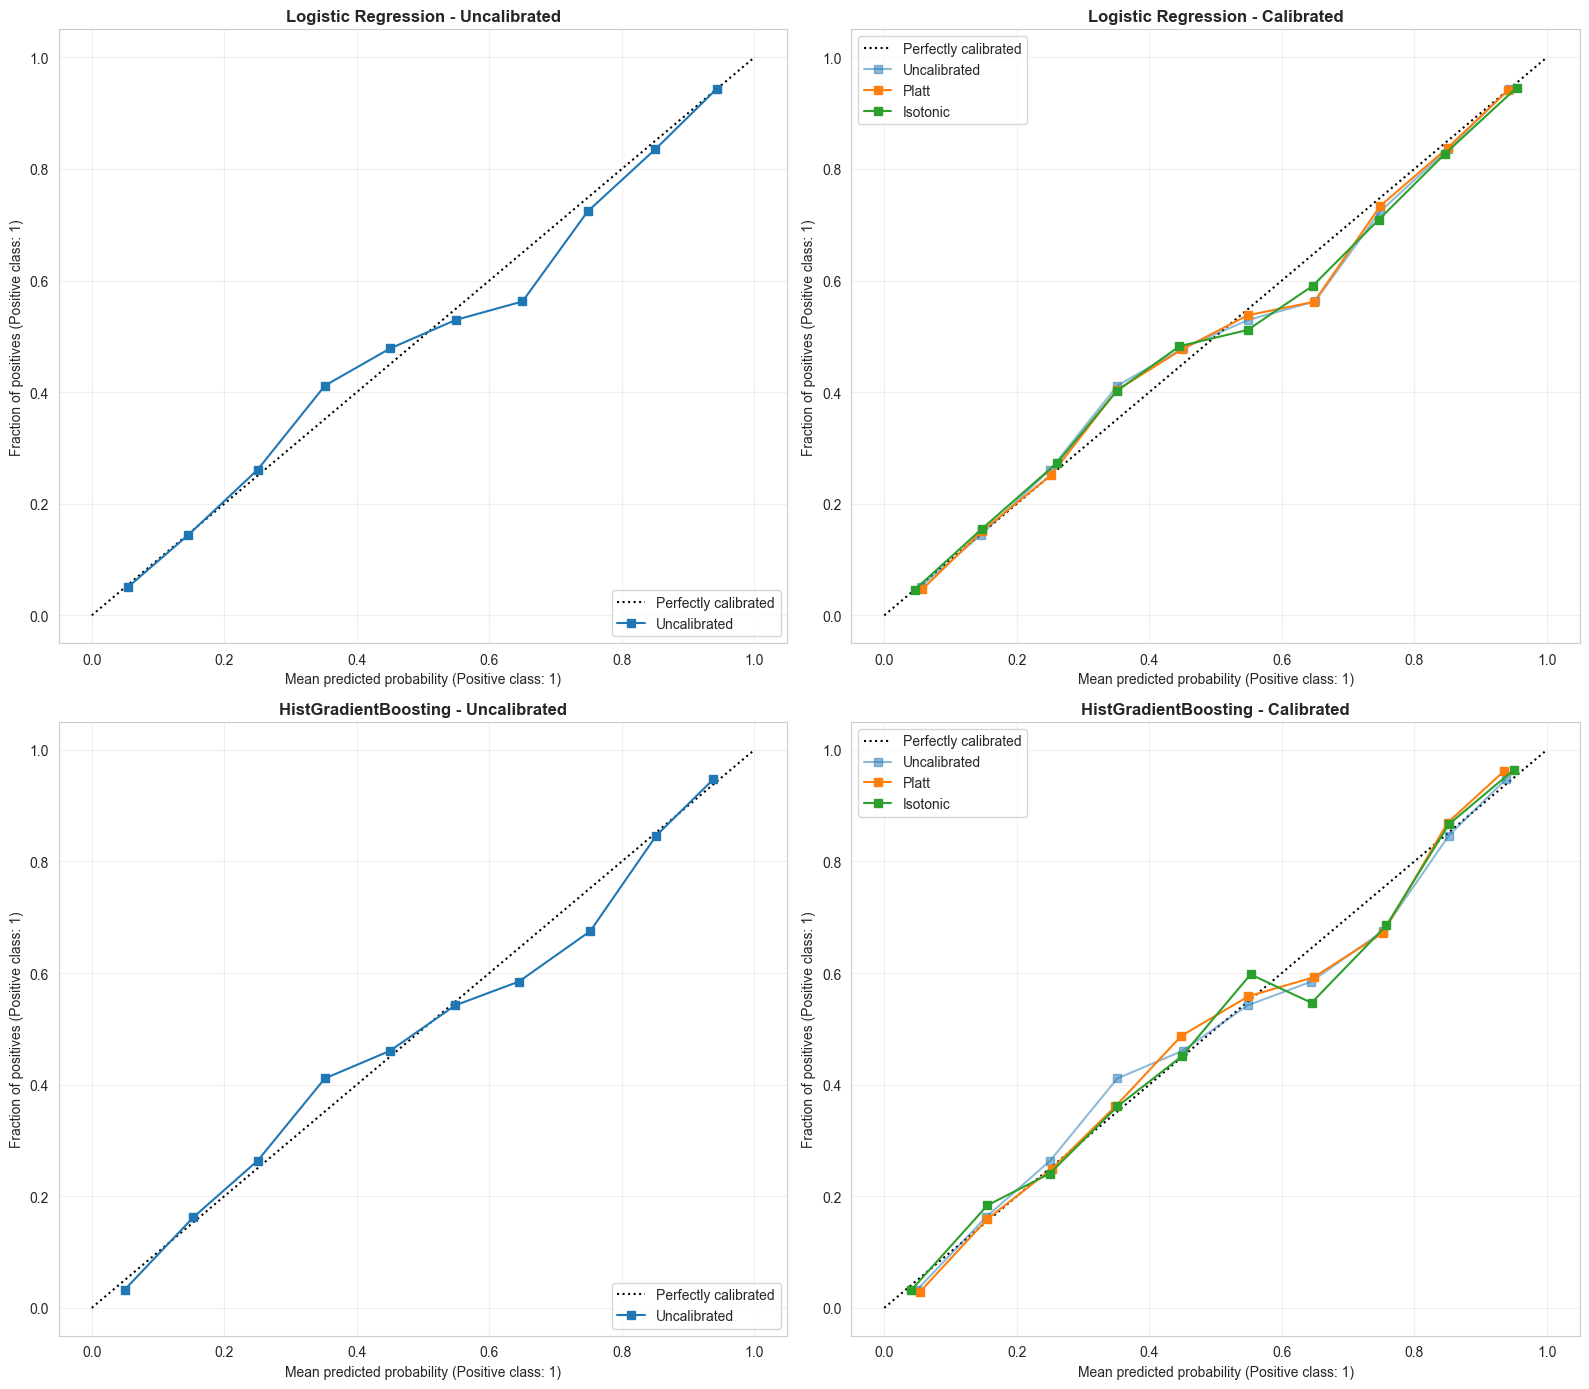

In [52]:
# Create comprehensive calibration plots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot for each model
for model_idx, model_name in enumerate(models.keys()):
    row = model_idx
    
    # Uncalibrated
    ax = axes[row, 0]
    y_proba = uncalibrated_predictions[model_name]
    CalibrationDisplay.from_predictions(
        y_test, y_proba,
        n_bins=10,
        ax=ax,
        name='Uncalibrated'
    )
    ax.set_title(f'{model_name} - Uncalibrated', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Calibrated (both methods)
    ax = axes[row, 1]
    y_proba_uncal = uncalibrated_predictions[model_name]
    CalibrationDisplay.from_predictions(
        y_test, y_proba_uncal,
        n_bins=10,
        ax=ax,
        name='Uncalibrated',
        alpha=0.5
    )
    
    for cal_method in ['Platt', 'Isotonic']:
        y_proba_cal = calibrated_predictions[model_name][cal_method]
        CalibrationDisplay.from_predictions(
            y_test, y_proba_cal,
            n_bins=10,
            ax=ax,
            name=cal_method
        )
    
    ax.set_title(f'{model_name} - Calibrated', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


## 9. Select Best Calibrated Model

We'll select the best model based on calibration metrics (ECE and Brier Score) while maintaining discrimination (ROC-AUC).


In [53]:
# Find best model for each metric
print("=" * 90)
print("BEST MODELS BY METRIC")
print("=" * 90)

print(f"\nBest ECE (lower is better):")
best_ece = results_df.loc[results_df['ECE'].idxmin()]
print(f"  {best_ece['Model']} - {best_ece['Calibration']}: {best_ece['ECE']:.4f}")

print(f"\nBest Brier Score (lower is better):")
best_brier = results_df.loc[results_df['Brier Score'].idxmin()]
print(f"  {best_brier['Model']} - {best_brier['Calibration']}: {best_brier['Brier Score']:.4f}")

print(f"\nBest Log Loss (lower is better):")
best_logloss = results_df.loc[results_df['Log Loss'].idxmin()]
print(f"  {best_logloss['Model']} - {best_logloss['Calibration']}: {best_logloss['Log Loss']:.4f}")

print(f"\nBest ROC-AUC (higher is better):")
best_rocauc = results_df.loc[results_df['ROC-AUC'].idxmax()]
print(f"  {best_rocauc['Model']} - {best_rocauc['Calibration']}: {best_rocauc['ROC-AUC']:.4f}")

# Select best overall (weighted by calibration importance)
# Combine ECE and Brier Score (both measure calibration quality)
results_df['Calibration_Score'] = (results_df['ECE'] + results_df['Brier Score']) / 2
results_df['Combined_Score'] = results_df['ROC-AUC'] - results_df['Calibration_Score']

print(f"\n" + "=" * 90)
print("BEST OVERALL MODEL (Balancing Discrimination and Calibration):")
print("=" * 90)
best_overall = results_df.loc[results_df['Combined_Score'].idxmax()]
print(f"  Model: {best_overall['Model']}")
print(f"  Calibration: {best_overall['Calibration']}")
print(f"  ROC-AUC: {best_overall['ROC-AUC']:.4f}")
print(f"  ECE: {best_overall['ECE']:.4f}")
print(f"  Brier Score: {best_overall['Brier Score']:.4f}")
print(f"  Log Loss: {best_overall['Log Loss']:.4f}")

# Store best model info
best_model_name = best_overall['Model']
best_cal_method = best_overall['Calibration']
print(f"\n[OK] Best model selected: {best_model_name} with {best_cal_method} calibration")


BEST MODELS BY METRIC

Best ECE (lower is better):
  Logistic Regression - Platt: 0.0225

Best Brier Score (lower is better):
  Logistic Regression - Platt: 0.1798

Best Log Loss (lower is better):
  Logistic Regression - Platt: 0.5316

Best ROC-AUC (higher is better):
  Logistic Regression - Uncalibrated: 0.8058

BEST OVERALL MODEL (Balancing Discrimination and Calibration):
  Model: Logistic Regression
  Calibration: Platt
  ROC-AUC: 0.8058
  ECE: 0.0225
  Brier Score: 0.1798
  Log Loss: 0.5316

[OK] Best model selected: Logistic Regression with Platt calibration


## 10. Threshold Analysis

For different use cases, we may want different decision thresholds. Let's analyze threshold performance.


In [54]:
# Use best calibrated model for threshold analysis
best_y_proba = calibrated_predictions[best_model_name][best_cal_method]

# Calculate metrics at different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred = (best_y_proba >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

threshold_df = pd.DataFrame(threshold_results)
print("Threshold Analysis:")
print("=" * 90)
print(threshold_df.round(4).to_string(index=False))
print("=" * 90)


Threshold Analysis:
 Threshold  Accuracy  Precision  Recall  F1-Score  TP  TN  FP  FN
      0.10    0.5683     0.5364  0.9929    0.6965 979 144 846   7
      0.15    0.6103     0.5626  0.9848    0.7161 971 235 755  15
      0.20    0.6336     0.5799  0.9645    0.7243 951 301 689  35
      0.25    0.6650     0.6057  0.9412    0.7371 928 386 604  58
      0.30    0.6898     0.6316  0.9077    0.7449 895 468 522  91
      0.35    0.7019     0.6514  0.8661    0.7436 854 533 457 132
      0.40    0.7115     0.6742  0.8164    0.7385 805 601 389 181
      0.45    0.7257     0.7026  0.7809    0.7397 770 664 326 216
      0.50    0.7161     0.7119  0.7241    0.7179 714 701 289 272
      0.55    0.7161     0.7396  0.6653    0.7005 656 759 231 330
      0.60    0.7075     0.7622  0.6014    0.6723 593 805 185 393
      0.65    0.7039     0.7944  0.5487    0.6491 541 850 140 445
      0.70    0.6953     0.8288  0.4909    0.6166 484 890 100 502
      0.75    0.6751     0.8629  0.4148    0.5603 409 92

## 11. Visualize Threshold Performance


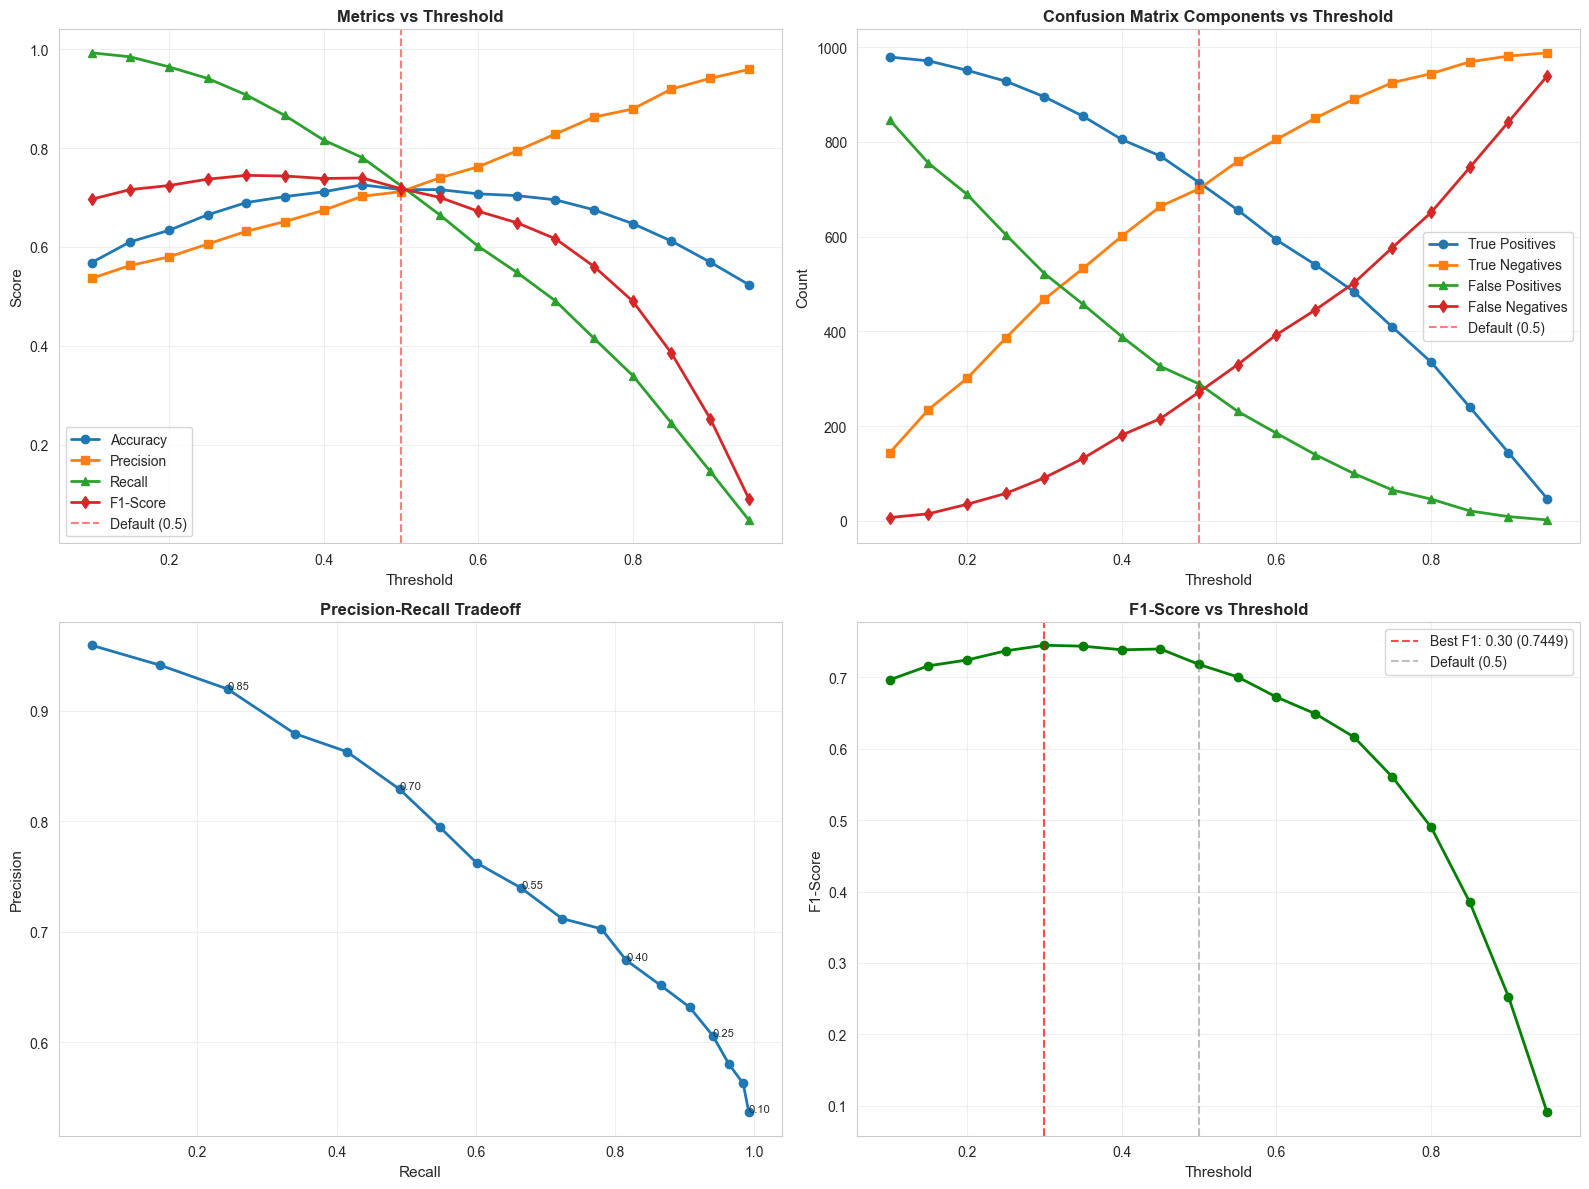


Best F1-Score threshold: 0.30 (F1 = 0.7449)


In [55]:
# Plot threshold analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy, Precision, Recall, F1
ax = axes[0, 0]
ax.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 's-', label='Precision', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], '^-', label='Recall', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'd-', label='F1-Score', linewidth=2)
ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Metrics vs Threshold', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Confusion matrix components
ax = axes[0, 1]
ax.plot(threshold_df['Threshold'], threshold_df['TP'], 'o-', label='True Positives', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['TN'], 's-', label='True Negatives', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['FP'], '^-', label='False Positives', linewidth=2)
ax.plot(threshold_df['Threshold'], threshold_df['FN'], 'd-', label='False Negatives', linewidth=2)
ax.axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Confusion Matrix Components vs Threshold', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# Precision-Recall tradeoff
ax = axes[1, 0]
ax.plot(threshold_df['Recall'], threshold_df['Precision'], 'o-', linewidth=2, markersize=6)
for i, thresh in enumerate(threshold_df['Threshold']):
    if i % 3 == 0:  # Label every 3rd point
        ax.annotate(f'{thresh:.2f}', 
                   (threshold_df['Recall'].iloc[i], threshold_df['Precision'].iloc[i]),
                   fontsize=8)
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Tradeoff', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# F1-Score vs Threshold
ax = axes[1, 1]
ax.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'o-', linewidth=2, color='green')
best_f1_idx = threshold_df['F1-Score'].idxmax()
best_f1_thresh = threshold_df.loc[best_f1_idx, 'Threshold']
best_f1_score = threshold_df.loc[best_f1_idx, 'F1-Score']
ax.axvline(x=best_f1_thresh, color='r', linestyle='--', alpha=0.7, 
           label=f'Best F1: {best_f1_thresh:.2f} ({best_f1_score:.4f})')
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('F1-Score', fontsize=11)
ax.set_title('F1-Score vs Threshold', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest F1-Score threshold: {best_f1_thresh:.2f} (F1 = {best_f1_score:.4f})")


## 12. Summary and Recommendations


In [56]:
print("=" * 90)
print("CALIBRATION AND THRESHOLD ANALYSIS SUMMARY")
print("=" * 90)

print(f"\nSelected Best Model:")
print(f"  Model: {best_model_name}")
print(f"  Calibration Method: {best_cal_method}")
print(f"  ROC-AUC: {best_overall['ROC-AUC']:.4f}")
print(f"  ECE: {best_overall['ECE']:.4f}")
print(f"  Brier Score: {best_overall['Brier Score']:.4f}")

print(f"\nThreshold Recommendations:")
print(f"  Default threshold (0.5): Balanced precision and recall")
print(f"  Best F1-Score threshold: {best_f1_thresh:.2f}")
print(f"  High confidence threshold (0.7+): When you need high precision")
print(f"  Low confidence threshold (0.3-): When you need high recall")

print(f"\nKey Findings:")
print(f"  1. Calibration improves probability reliability")
print(f"  2. {best_cal_method} calibration performs best for {best_model_name}")
print(f"  3. Threshold selection depends on use case (precision vs recall tradeoff)")
print(f"  4. Well-calibrated probabilities are essential for win probability estimation")

print("\n" + "=" * 90)
print("\nNote: This calibrated model should be used for final predictions and reporting.")
print("=" * 90)


CALIBRATION AND THRESHOLD ANALYSIS SUMMARY

Selected Best Model:
  Model: Logistic Regression
  Calibration Method: Platt
  ROC-AUC: 0.8058
  ECE: 0.0225
  Brier Score: 0.1798

Threshold Recommendations:
  Default threshold (0.5): Balanced precision and recall
  Best F1-Score threshold: 0.30
  High confidence threshold (0.7+): When you need high precision
  Low confidence threshold (0.3-): When you need high recall

Key Findings:
  1. Calibration improves probability reliability
  2. Platt calibration performs best for Logistic Regression
  3. Threshold selection depends on use case (precision vs recall tradeoff)
  4. Well-calibrated probabilities are essential for win probability estimation


Note: This calibrated model should be used for final predictions and reporting.
